In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from random import choice, randint, seed

from pydrake.geometry.optimization import HPolyhedron
from pydrake.solvers import MosekSolver

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from models.maze import Maze

# Construction of the maze

In [2]:
seed(4)

maze_size = 50
knock_downs = 100

start = np.array([0.5, 0])
goal = np.array([maze_size - 0.5, maze_size])
maze = Maze(maze_size, maze_size)
maze.make_maze()

while knock_downs > 0:
    cell = maze.cell_at(randint(1, maze_size - 2), randint(1, maze_size - 2))
    walls = [w for w, up in cell.walls.items() if up]
    if len(walls) > 0:
        maze.knock_down_wall(cell, choice(walls))
        knock_downs -= 1

regions = []
edges = []
for x in range(maze_size):
    for y in range(maze_size):
        regions.append(HPolyhedron.MakeBox([x, y], [x+1., y+1.]))
        C = y + x * maze.ny
        if not maze.map[x][y].walls['N']:
            edges.append((C, C + 1))
        if not maze.map[x][y].walls['S']:
            edges.append((C, C - 1))
        if not maze.map[x][y].walls['E']:
            edges.append((C, C + maze.ny))
        if not maze.map[x][y].walls['W']:
            edges.append((C, C - maze.ny))

# Minimum-distance problem

In [3]:
def plot_maze():
    plt.figure(figsize=(5,5))
    plt.axis('equal')
    maze.plot(1)
    plt.plot(*start, 'kx', markersize=10)
    plt.plot(*goal, 'kx', markersize=10)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Finished 100 rounding trials.


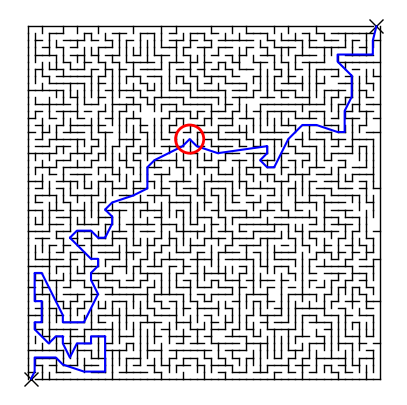

In [4]:
relaxation = True
gcs = LinearGCS(regions, edges)
gcs.addSourceTarget(start, goal)
gcs.setSolver(MosekSolver())
waypoints = gcs.SolvePath(relaxation)[0]

plot_maze()
def plot_circle():
    coll = PatchCollection([plt.Circle((23, 34), 2)], linewidth=2, fc='None', ec='r', zorder=3)
    plt.gca().add_collection(coll)
plot_circle()
plt.plot(*waypoints, 'b')
plt.savefig('maze_length.pdf', bbox_inches='tight')

# Minimum-time problem

In [5]:
qdot_min = -1
qdot_max = 1
velocity = np.zeros((2, 2))
order = 6
continuity = 2
hdot_min = 1e-1
regularizer = [1e-1, 1e-1]
st_edges = [[0], [-1]]

gcs = BezierGCS(regions, order, continuity, edges, hdot_min=hdot_min)
gcs.setSolver(MosekSolver())
gcs.setPaperSolverOptions()
gcs.addTimeCost(1)
gcs.addDerivativeRegularization(*regularizer, 2)
gcs.addVelocityLimits([qdot_min] * 2, [qdot_max] * 2)
gcs.addSourceTarget(start, goal, edges=st_edges, velocity=velocity)
traj = gcs.SolvePath(relaxation)[0]

In [ ]:
n_samples = 5000

times = np.linspace(traj.start_time(), traj.end_time(), n_samples)
waypoints = np.squeeze([traj.value(t) for t in times]).T

plot_maze()
plot_circle()
plt.plot(*waypoints, 'b')

plt.savefig('maze_time.pdf', bbox_inches='tight')